In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import json
import seaborn as sns
import itertools
import math 
from sklearn import tree

from collections import Counter

# Introduction

In this workbook we compare three different strategies for playing GuessWho:
    
* Safe (Pessimistic) - choose the question, that in the worst case removes the most cards
* Random - choose a random card
* Risky (Optimistic) - choose the question, that in the best case removes the most cards

We will see that of these three Safe is best followed by Random and Risky is the worst strategy.

At the end we compare with a Decision Tree generated by sklearn. The optimised tree is significantly better.

### Read the encoded Guess Who data

In [2]:
gw_df = pd.read_csv('data/data.csv')
gw_df.head()

,name,woman,hat,glasses,blue eyes,earrings,facial hair,beard,moustache,bald,blond hair,black hair,white hair,brown hair,red hair,eurasian
0,Anita,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1
1,Anne,1,0,1,1,1,0,0,0,0,0,0,1,0,0,1
2,Bernard,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Carmen,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Charles,0,0,1,0,0,1,0,1,1,0,0,1,0,0,1


### Prepare data for simulation

In [3]:
#dictionary to look up names
dColumn = {}

#remove the names and replace question names with ids
#save ids to dictionary for later
cards = gw_df.drop(['name'], axis=1)
for i, n in enumerate(cards.columns):
    dColumn[i] = n
    cards.rename(index=str, columns={n: i}, inplace=True)


### Player Object 

In [4]:

class Player:
    
    def __init__(self, cards, solution=None):
        
       
        #set up the card information
        self.cards = cards.copy()
        self.cards['target'] = True
        
        #set up the question information
        self.questions = pd.DataFrame(index=list(range(len(cards.columns))))
        self.questions['asked'] = False
        self.questions['prob'] = 0
        
        self.updateQuestionProb()
        
        self.answeredByDefault()
        
        #select the card ('who') you are trying to guess
        if solution == None:
            self.solution = random.randrange(0, len(cards)) 
        else:
            self.solution = solution
        
                
    def ask(self, qindex):
        
        # ask a question and reject failed cards
        
        # get the answer to the question
        answer = self.cards.iloc[self.solution][qindex]
              
        # identify cards that don't match and set to false
        self.cards.loc[self.cards[qindex]!=answer, 'target'] = False
        
        # log that the question has been asked
        self.questions.loc[qindex, 'asked'] = True
        
        # recalculate the number of cards that will remain if the question is true
        self.updateQuestionProb()
        
        # also remove any questions that have been answered by default
        # eg if it is a woman remove, 'bald'
        self.answeredByDefault()
        
        return answer 
        
    def answeredByDefault(self):
        
        # set as 'asked' any questions that are redundant
        # eg if it is a woman remove, 'bald'
        
        self.questions.loc[self.questions[(self.questions.prob==0)|(self.questions.prob==1)].index, 'asked'] = True

        
    def solved(self):      
        
        # check if the there is only one solution remaining
        if self.cards[self.cards.target].target.count() > 1: 
            return False 
        else: 
            return True       
        
    
    def updateQuestionProb(self):
        
        # with the remaining cards
        # for each question
        # calculate the percentage of cards left if the answer to the question is true
        
        remainingCount = self.cards[self.cards.target].target.count()
        
        self.questions = pd.merge(self.questions, self.cards[self.cards.target].sum().reset_index(), left_index=True, right_index=True)
        self.questions.prob = self.questions[0] / remainingCount
        self.questions = self.questions[['asked', 'prob']]

        




### And create some strategies

In [5]:

class Strategy:
    
    def random(q):
        
        #Strategy Random: ask a random question that has not been asked before
        
        return random.choice(q[q.asked==False].index)
    
    
    def risky(q):
        
        #Strategy Risky: ask the question that might leave the fewest cards
        
        t = q[q.asked==False].copy()
        t['val'] = t.prob - 0.5
        t.val = t.val.abs()
 
        return random.choice(t[t.val==t.val.max()].index)

            
    def safe(q):
        
        #Strategy Safe: ask the question that will as close as possible remove half the remaining cards
        
        t = q[q.asked==False].copy()
        t['val'] = t.prob - 0.5
        t.val = t.val.abs()
        
        return random.choice(t[t.val==t.val.min()].index)

    
strategy = Strategy


### Parameters for the simulation

In [6]:
gamesCount = 1000 # number of games to play
strategies = ['Risky', 'Random', 'Safe'] 

### Run the simulation

Depending on how many games you want to run this takes some time.

You can skip this step and use the data provided in the data folder

In [ ]:
rawResults = []

run = 0 

# for each strategy
for s in strategies:
    

    result = {'strategy': s}
    
    # select the strategy function 
    if s == 'Random':
        f = strategy.random
    if s == 'Risky':
        f = strategy.risky
    if s == 'Safe':
        f = strategy.safe

    games = []
    # play the games
    for g in range(gamesCount):
        
        # initate a new game
        p = Player(cards)  

        rounds = 0 
        # use the strategy to select questions
        # until the you have guessed who
        while p.solved() == False:
            qId = f(p.questions)
            p.ask(qId)
            rounds+=1
        
        # save how many rounds(questions) it took to guess who
        games.append(rounds) 

        run+=1
        if run % 100 == 0:
            print(run)
    
    # save the results for the strategy 
    result['score'] = np.mean(games)
    result['std'] = np.std(games)
    result['rounds'] = games
    rawResults.append(result)
    
#save the resutls to a json file
with open('data/risky_random_safe_1000_games.json', 'w') as fp:
    json.dump(rawResults, fp)

### Read the pre provided data

In [7]:
# read the results into a dataframe
rawResults = pd.read_json('data/risky_random_safe_1000_games.json')

### Distribution of scores

In [8]:
def plotDist(rawResults, color, figsize=(8,6), sharey=True, filename='plot.png'):
    
    f, axes = plt.subplots(len(color), 1, figsize=figsize, sharex=True, sharey=sharey)
    sns.despine(left=True)
    sns.set(style='white', palette='muted', color_codes=True)


    for i  in list(rawResults.index):
        res = rawResults.iloc[i]
        d = res.rounds
        sns.distplot(d, kde=False, color=color[res['strategy']], ax=axes[i], bins=np.arange(2,16,1))
        
        axes[i].text(8.2, axes[i].get_ylim()[1]*.4, '{:.1f}'.format(res['score']), ha='center', fontweight='bold', fontsize=18)
        axes[i].text(8.2, axes[i].get_ylim()[1]*.2, 'average turns (stdev: {:.1f})'.format(res['score'], res['std']), ha='center')
        axes[i].set_title('{}'.format(res['strategy']), fontsize=14, loc='left', color=color[res['strategy']], va='top')
           
        axes[i].set_yticks([])
    
    plt.tight_layout()

        
    plt.xlabel('Turns to Guess Who', fontsize=14)
    
    plt.suptitle('Results from {} games of Guess Who'.format(len(d)), fontsize=18, y=1)
    

    plt.savefig(filename, bbox_inches='tight')
    plt.show()

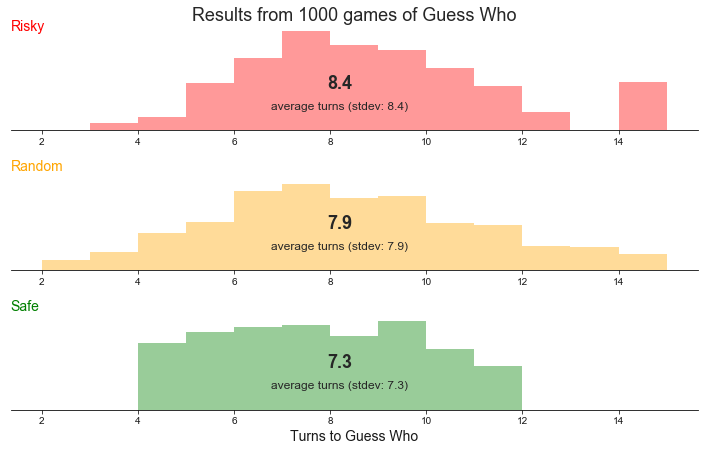

In [9]:
plotDist(rawResults, color={'Random':'orange', 'Risky':'red', 'Safe':'green'}, figsize=(10,6), filename='images/dist3.png')

While the risky and random strategies sometimes find the solution faster

You can see that the safe strategy is on average better reaching the solution 11% faster

### Compare Head to Head

In [10]:
# Plot stacked bar chart 

def head2head(p1, p2):
    
    p1Score = 0
    p2Score = 0

    for i in range(len(p1)):
        
        if p1[i] < p2[i]:
            p1Score += 1
        elif p1[i] > p2[i]:
            p2Score += 1
        elif i % 2 == 0:
            p1Score += 1 
        else:
            p2Score += 1

    return(p1Score/len(p1), p2Score/len(p1))

def plotHeadToHead(df, color, title='Head To Head', filename='plot.png'):
    
    
    # plotting the stacked bar chart is convoluted
    
    # the colors need to be in the ordered with most wins first
    
    # get head to head combinations
    combi = list(itertools.combinations(range((len(color))), 2))
    
    # create dictionary to store the data
    hth = {
        'color': color,
        'order': [],                       # the order of the head to heads
        'score': {                         # score = actual number of games won
            'Safe': np.zeros(len(combi)),
            'Random': np.zeros(len(combi)),
            'Risky': np.zeros(len(combi)),
            'DTC': np.zeros(len(combi)),
        }, 
        'height':{                          # height = the height of the bar
            'Safe': np.zeros(len(combi)),
            'Random': np.zeros(len(combi)),
            'Risky': np.zeros(len(combi)),
            'DTC': np.zeros(len(combi)),
        }
    }
    
    # calcuate the head to head score and save to dictionary
    for i, c in enumerate(combi):

        A = df.iloc[c[0]].strategy
        B = df.iloc[c[1]].strategy

        resA = df.iloc[c[0]].rounds
        resB = df.iloc[c[1]].rounds

        outcome = head2head(resA, resB)

        hth['order'].append('{} v {}'.format(A, B))

        hth['score'][A][i] = outcome[0]
        hth['score'][B][i] = outcome[1]

        if outcome[0] > outcome[1]:
            hth['height'][A][i] = 1
            hth['height'][B][i] = outcome[1]
        else:
            hth['height'][A][i] = outcome[0]
            hth['height'][B][i] = 1
    
    
    # plot the bars
    f, ax = plt.subplots(1, 1, figsize=(12, 4))

    sns.set(style='white', palette='muted', color_codes=True)

    for s in hth['color']:
        
        x = list(range(len(hth['score'][s])))

        # plot a white bar to avoid discolouration and then the color bar
        sns.barplot(x = x, y = hth['height'][s], color = 'white' , label=s, alpha=1)
        sns.barplot(x = x, y = hth['height'][s], color = hth['color'][s], label='Random', alpha=0.5)

        # add the labels
        for i, v in enumerate(hth['score'][s]):
            if v > 0.2:
                y = hth['height'][s][i]                
                ax.text(i, y-0.15, '{}'.format(s), fontsize=14, ha='center')
                ax.text(i, y-0.3, '{0:.0f}%'.format(v*100), fontweight='bold', fontsize=22, ha='center')

    ax.set_xticklabels(hth['order'], fontsize=14)#, color='grey')
    ax.set_ylabel('Games Won', fontsize=14)#, color='grey')
    ax.set_yticks([])

    sns.despine(left=True)
    # plt.setp(axes, yticks=[])


    plt.title(title, fontsize=18)#, color='grey')
    
    plt.savefig(filename, bbox_inches='tight')
    plt.show()
    


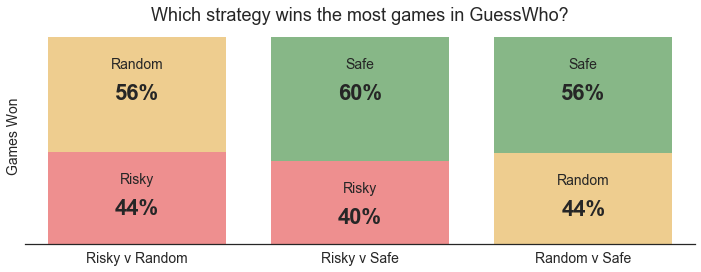

In [11]:
title = 'Which strategy wins the most games in GuessWho?'
plotHeadToHead(rawResults, color={'Safe': 'green', 'Random':'orange', 'Risky':'red'}, title=title, filename=('images/hth3.png'))

The 11% reduction in turns to solution by the safe strategy translates to 50% more wins than the risky strategy

### Binary Search

Compare the results against a binary search of an uncorrolated state space

We look at the number of itterations to find the target of similar sized state space, using different ratios to split the remaining state space.

In [12]:


def nextTestval(response, ratio, minval, maxval): 
    
    # select a test value according the the ratio between min and max values
    
    testval = minval + (maxval - minval) * ratio
    
    # round to integer such that rounding does not prevent solution
    if response == 1:
        testval = math.floor(testval)
    if response == -1:
        testval = math.ceil(testval)
            
    return testval 
        

def testSolution(testval, solution, minval, maxval):
    
    # check if the test value is equal to, less than or more than solution
    
    if testval == solution:
        response = 0
    if testval < solution:
        minval = testval
        response = -1
    if testval > solution:
        maxval = testval
        response = 1
    return response, minval, maxval


def runTest(originalMinval, originalMaxval, ratio, runs):
    
    results = []
    
    # loop through the number of runs
    
    for run in range(runs):
        
        # reset the min and max values in the search space
        minval = originalMinval
        maxval = originalMaxval
        
        # select a random target
        solution = random.choice(range(minval+1, maxval))

        response = 1
        counter = 0
        
        # conduct search
        while response != 0:
            testval = nextTestval(response, ratio, minval, maxval)
            response, minval, maxval = testSolution(testval, solution, minval, maxval)
            counter+=1
        
        # record iterations to solution
        results.append(counter)
    
    return results


In [13]:
minval = 0
maxval = 2**15 #matching the number of possible question combinations in the guess who card deck

runs = 10000

results = []

for ratio in np.arange(0.1, 0.55, 0.05):
    result = runTest(minval, maxval, ratio,  runs)
    
    results.append({'ratio': ratio, 'average':np.mean(result), 'stdev': np.std(result)})
    
results = pd.DataFrame(results)  

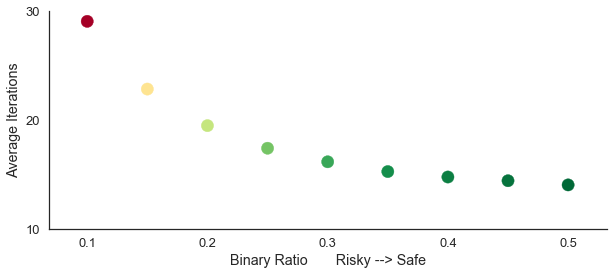

In [14]:
sns.set(style='white', context='talk')
f, ax= plt.subplots(figsize=(10, 4))

plt.scatter(x=results['ratio'], y=results['average'],
                     c=results['average'], s=150, cmap='RdYlGn_r')


ax.set_xlabel('Binary Ratio       Risky --> Safe')
ax.set_ylabel('Average Iterations')
ax.set_yticks(np.arange(10, 31, 10))
sns.despine()#bottom=True, left=True)

plt.show()

In an uncorrolated state space the shortest average distance from root to leaf on a binary tree will always be when the remaing vaules are divided in half.

We see here that the average number of iterations is higher than the GuessWho example.

This is because corrolations in the GuessWho questions (all earings are on women, all blondes do not have white hair) reduces the number of iterations.



### Random decks

Here we explore random decks of different sizes with different numbers of possible questions


Define a function that creates a random deck

In [15]:
get_bin = lambda x, n: format(x, 'b').zfill(n)

def createCards(questionCount, cardCount):
    
    # create a card deck
    
    # each card can be represented by a set of binary answers to a set of questions
    # so each card can be represented by a binary number between 0 and 2**number_of_questions
    
    # questionCount = number of different binary questions eg., man, blond, glasses
    # cardCount = total number of cards

    cards = [] # array holding cards

    # create cards 
    
    # 
    #select a random sample of integers in the range of possible number
    for i in random.sample(list(range(2**questionCount)), cardCount):   

        question = []
        
        #convert the integer to binary and store the bits in an array
        for f in get_bin(i, questionCount):
             question.append(int(f))
        
        #save the card to the deck
        cards.append(question)               

    # convert to data frame
    cards = pd.DataFrame(cards, index=list(range(len(cards))), columns=list(range(len(cards[0]))))

    return cards

In [16]:
# set configuration values for simulation

questionCountList = [5] # list of question numbers to simulate
# i = 5
# while i < 25:
#     questionCountList.append(i)
#     i+=3

cardCountList = [5, 10, 15, 20, 25, 30, 35] # list of deck sizez to simulate

deckCount = 100 # number of differnt random decks to generate
 
gamesCount = 10 # number of games to play with each deck

strategies = ['Random', 'Risky', 'Safe']


### Run the simulation

Depending on how many games you want to run this takes some time.

You can skip this step and use the data provided in the data folder

In [ ]:

# run the simulation

rawResults = []

run = 0 

# loop through variables
for cardCount in cardCountList:

    for questionCount in questionCountList:

        # only create decks where there are enough unique question combinations for the number of cards
        if 2**questionCount >= cardCount: 
            
            # create random card decks 
            for deck in range(deckCount):
                
                cards = createCards(questionCount, cardCount)
                
                # for each card deck play the games for each strategy
                for s in strategies:

                    result = {'cards': cardCount, 'questions': questionCount, 'deck': deck, 'strategy': s}

                    if s == 'Random':
                        f = strategy.random
                    if s == 'Risky':
                        f = strategy.risky
                    if s == 'Safe':
                        f = strategy.safe

                    games = []
                    for g in range(gamesCount):

                        p = Player(cards)  

                        averageProb = p.questions.prob.mean()

                        rounds = 0
                        while p.solved() == False:
                            qId = f(p.questions)
                            p.ask(qId)
                            rounds+=1
                        games.append(rounds) 

                        run+=1
                        if run % 1000 == 0:
                            print(run)
                    
                    #save the results
                    result['score'] = np.mean(games)
                    result['avererage_prob'] = averageProb
                    #result['std'] = np.std(games)

                    rawResults.append(result)

with open('data/randomDeck_1000_games.json', 'w') as fp:
    json.dump(rawResults, fp)



In [ ]:
rawResults = pd.read_json('data/randomDeck_1000_games.json')

In [ ]:
color = {'Risky':'red', 'Random':'orange', 'Safe':'green'}

cardCountList = [10, 15, 20, 25]

sns.set(style='white', context='talk')

fig, axs = plt.subplots(1, 4, figsize=(10, 8), sharex=True, sharey=True)

for i, cardCount in enumerate(cardCountList):
    
    
    for s in strategies:
    
        df = rawResults[(rawResults.cards==cardCount)&(rawResults.strategy==s)]

        axs[i] = sns.regplot(x=df.questions, y=df.score, ax=axs[i], label=s, 
                             scatter_kws={'s': 0}, color=color[s],
                             logx=True, ci=100)
                             #x_estimator=np.mean, truncate=True)
       
        axs[i].set_ylim([3,6])
        axs[i].set_yticks([3, 4, 5, 6])
        
        axs[i].set_title('{} cards'.format(cardCount))
        
        if i == 0:
            axs[i].set_xlabel('Total possible questions at start of game', ha='left')
            axs[i].set_ylabel('Turns to GuessWho')
            
        else:
            axs[i].xaxis.label.set_visible(False)

        
plt.suptitle('Comparing card decks of different sizes and questions')      
        
plt.show()


We can see a number of different characteristics from different sized decks and number of questions (state space size):
    
* As the number of cards goes up: so does the number of turns. This is because there are more cards to guess from 


* As the number of questions goes up: Safe stays relatively flat as optmising for the worst case and cutting the remaining cards in half each turn, means the the number of turns is primarily dictated by the number of cards.


* As the the number of questions goes up: the number of turns for Risky increases. This is because as the size of the state space increases relative to the number of cards there will be riskier questions available. And riskier questions mean worse average results

### Decision Tree

We now compare the results using a decision tree generated with sklearn

In [ ]:
# create 2d array of cards and questions
data = gw_df.as_matrix(columns=gw_df.columns[1:])

# create 1d array of corrosponding target name
target = gw_df.name

Initiate sklearn Decision Tree Classifier and construct the tree

In [ ]:
clf = tree.DecisionTreeClassifier(criterion='entropy')
estimator = clf.fit(data, target)

Extract the structure of the tree

In [ ]:
children_left = estimator.tree_.children_left
children_right = estimator.tree_.children_right
feature = estimator.tree_.feature

### Run the simulation

Depending on how many games you want to run this takes some time.

You can skip this step and use the data provided in the data folder

In [ ]:
# run the simulation for the DTC (Decision Tree Classifier)

gamesCount= 1000

rawResults = []

run = 0 

result = {'strategy': 'DTC'}

games = []
for g in range(gamesCount):

    p = Player(cards)  

    rounds = 0
    node = 0
    while p.solved() == False:

        qId = feature[node]
        answer = p.ask(qId)

        if answer == 0:
            node = children_left[node]
        else:
            node = children_right[node]

        rounds+=1

    games.append(rounds) 

    run+=1
    if run % 100 == 0:
        print(run)

# save the results
result['score'] = np.mean(games)
result['std'] = np.std(games)
result['rounds'] = games

rawResults.append(result)

with open('dtc_1000_games.json', 'w') as fp:
    json.dump(rawResults, fp)

In [ ]:
# open the original (Risky Random and Safe) results
# and append the DTC results

rawResults  = pd.read_json('risky_random_safe_1000_games.json')
rawResults = rawResults.append(pd.read_json('dtc_1000_games.json'), ignore_index=True)

### Plot the results

In [ ]:
plotDist(rawResults, color={'Random':'orange', 'Risky':'red', 'Safe':'green', 'DTC': 'blue'}, 
         figsize=(10, 8), sharey=False, filename='images/dist4.png')

In [ ]:
plotHeadToHead(rawResults, color={'DTC':'blue', 'Safe': 'green', 'Random':'orange', 'Risky':'red'}, 
               filename='images/hth4.png')

You can see that using an optimised decision tree significantly improves results.

This is because the unlike the safe approach which looks to maximise the information gain in each turn the DT Classifier rejects trees that have high information gain near the root but which lead to slow information gain further down the tree. Instead choosing a tree that will give the fewest average number of nodes between root and leaf.